In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [2]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)


In [6]:
def get_index(prefix):
    client_sdf = spark.read.csv(f"{prefix}/*/client/0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    server_sdf = spark.read.csv(f"{prefix}/*/server/0-0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    return server_sdf.join(client_sdf, on='prefix')\
        .withColumn("duration", col("duration").cast(T.IntegerType()))\
        .withColumn("txns", col("txns").cast(T.IntegerType()))\
        .withColumn("clients", col("clients").cast(T.IntegerType()))\
        .withColumn("rate", col("rate").cast(T.IntegerType()))

# Throughput

In [52]:
THRP_PREFIX = "quick/asym90"

thrp_index_sdf = get_index(THRP_PREFIX).cache()
thrp_index_df = thrp_index_sdf.toPandas()\
    .convert_dtypes()\
    .astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32"
    })

thrp_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
0,file:///home/ctring/data/slog/quick/asym90/ddr_ts,1.0.1016,ddr_ts.conf,15,10000,1000,0,10,basic,100,...,2,0,2,100,50,3,10,1,-1,-1
1,file:///home/ctring/data/slog/quick/asym90/ddr_ts_with_clock_sync,1.0.1012,ddr_ts_with_clock_sync.conf,15,10000,1000,0,10,basic,100,...,2,0,2,100,50,3,10,1,-1,-1


## Compute everything or read from cache

In [37]:
IGNORE_CACHE = True

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=10,
        duration_sec=40
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_sdf):
    # Extract all prefixes in the index
    throughput_df = index_sdf.select("prefix").toPandas()
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(thrp_index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{THRP_PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(thrp_index_sdf),
    ignore_cache=IGNORE_CACHE,
)

file:///home/ctring/data/slog/quick/asym90/ddr_ts 13767.153202405301
file:///home/ctring/data/slog/quick/asym90/ddr_ts_with_clock_sync 8127.986836545162
Saved to: quick/asym90/throughput.parquet


## Compute incrementally (only run if needed)

### Update rows

In [115]:
tdf = throughput_df
MASK = (tdf['config_name'] == 'ddr_only.conf') & (tdf['wl:hot'] == 10000) & (tdf['wl:mh'] == 100) & (tdf["wl:mp"] == 50)
throughput_df.loc[MASK, "throughput"] = throughput_df.loc[MASK, :].apply(lambda r : compute_throughput(r["prefix"]), axis=1)
throughput_df.to_parquet(f'{THRP_PREFIX}/throughput.parquet')
print(f"Saved to: {f'{THRP_PREFIX}/throughput.parquet'}")

file:/home/ctring/data/slog/main/ycsb/ddr_only-hot10000mp50mh100 37641.852147931364
Saved to: main/ycsb/throughput.parquet


### Add new rows

In [127]:
new_rows = compute_all_throughputs(
    thrp_index_sdf.where(col("config_name") == "ddr_only_no_ddr.conf")
)

throughput_df = pd.concat([throughput_df, new_rows])

file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot10000mp0mh0 126913.74370409675
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot10000mp100mh0 48989.9348274513
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot10000mp50mh0 77912.7728713007
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot100mp0mh0 112105.85403670403
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot100mp100mh0 55390.55823149894
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot100mp50mh0 73646.73628771887


In [ ]:
throughput_df.to_parquet(cache_path)
print(f"Saved to: {cache_path}")

## Plot

<AxesSubplot:xlabel='wl:hot,wl:mp,wl:mh'>

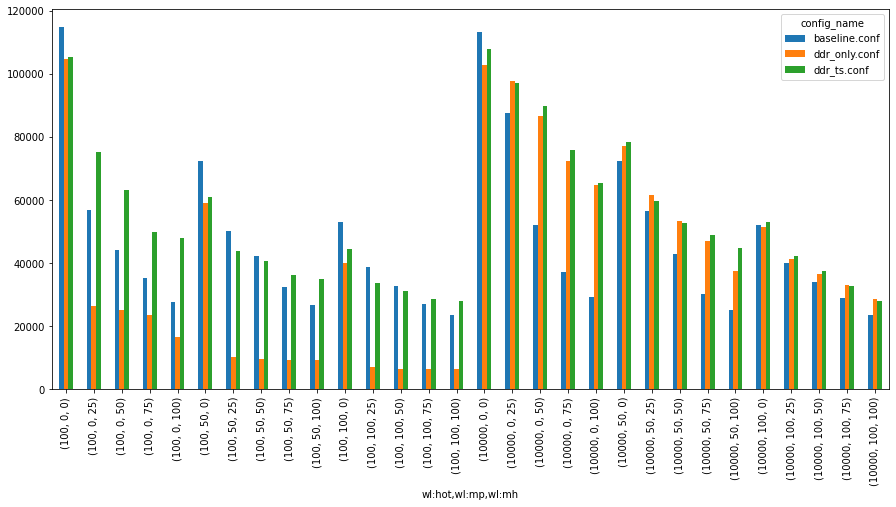

In [20]:
remove_constant_columns(throughput_df, ["config_name", "throughput"])
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = ["wl:hot", "wl:mp", "wl:mh"]

pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values)
pivoted.sort_index().plot.bar(figsize=(15, 7))

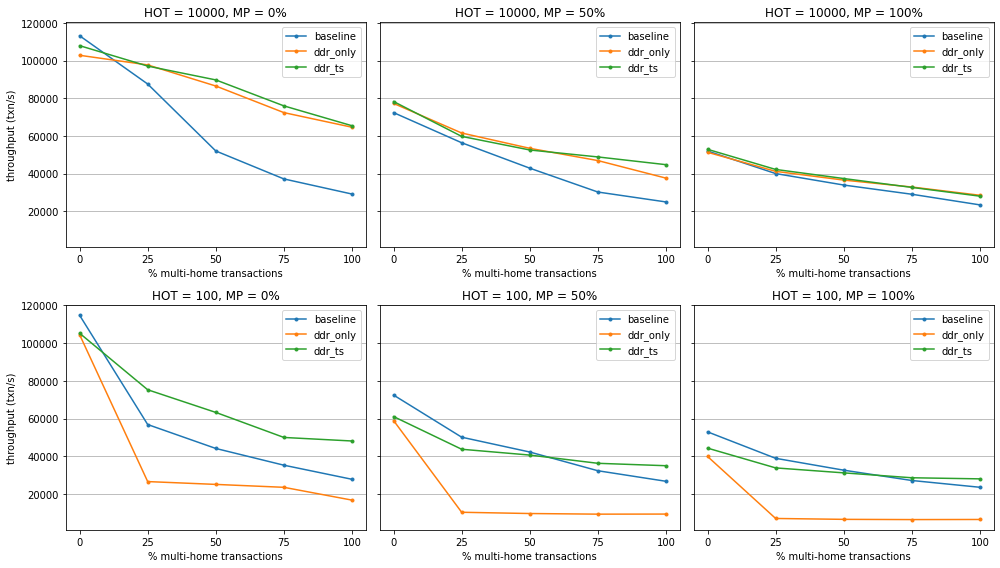

In [54]:
_, axes = plt.subplots(2, 3, figsize=(14, 8), sharey=True)

configs = throughput_df["config_name"].unique()
mp_pcts = sorted(throughput_df["wl:mp"].unique())
mh_pcts = sorted(throughput_df["wl:mh"].unique())
hots = sorted(throughput_df["wl:hot"].unique(), reverse=True)

for config in configs:
    for r, hot in enumerate(hots):
        for c, mp_pct in enumerate(mp_pcts):
            mask = (throughput_df["config_name"] == config) & (throughput_df["wl:mp"] == mp_pct) & (throughput_df["wl:hot"] == hot)
            label = config.replace('.conf', '')
            throughput_df[mask].sort_values("wl:mh").plot(ax=axes[r, c], x="wl:mh", y="throughput", label=label, marker='.')
            axes[r, c].set_title(f"HOT = {hot}, MP = {mp_pct}%")
            axes[r, c].set_ylabel("throughput (txn/s)")
            axes[r, c].set_xlabel("% multi-home transactions")
            axes[r, c].set_xticks(mh_pcts)
            axes[r, c].grid(axis='y')
    
plt.tight_layout()

# Deadlocks

In [53]:
mask = (
    (thrp_index_df["wl:hot"] == 100) &
    (thrp_index_df["wl:mp"] == 50) &
    (
        (thrp_index_df["config_name"] == "ddr_ts.conf") |
        (thrp_index_df["config_name"] == "ddr_only.conf")
    )
)
mask = (
    (thrp_index_df["wl:hot"] == 100) &
    (thrp_index_df["wl:mp"] == 0) &
    (
        (thrp_index_df["config_name"] == "ddr_ts_with_clock_sync.conf") |
        (thrp_index_df["config_name"] == "ddr_ts.conf")
    )
)
deadlocks_index_df = thrp_index_df[mask]
deadlocks_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
0,file:///home/ctring/data/slog/quick/asym90/ddr_ts,1.0.1016,ddr_ts.conf,15,10000,1000,0,10,basic,100,...,2,0,2,100,50,3,10,1,-1,-1
1,file:///home/ctring/data/slog/quick/asym90/ddr_ts_with_clock_sync,1.0.1012,ddr_ts_with_clock_sync.conf,15,10000,1000,0,10,basic,100,...,2,0,2,100,50,3,10,1,-1,-1


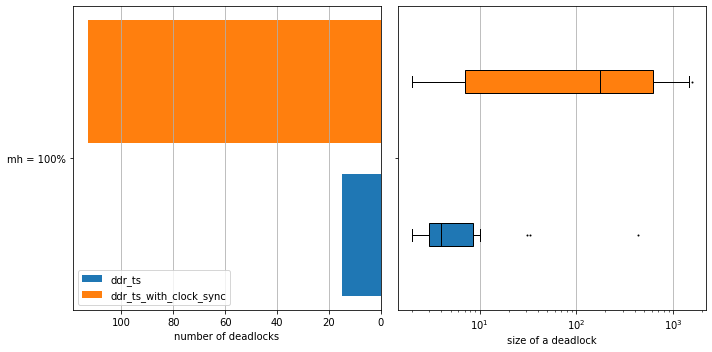

In [54]:
mh_pcts = [25, 50, 75, 100]
mh_pcts = [100]

configs = ["ddr_ts.conf", "ddr_only.conf"]
configs = ["ddr_ts.conf", "ddr_ts_with_clock_sync.conf"]

data = []
for config in configs:
    deadlocks = []
    num_txns = []
    for mh in mh_pcts:
        mask = (deadlocks_index_df["config_name"] == config) & (deadlocks_index_df["wl:mh"] == mh)
        prefix = deadlocks_index_df.loc[mask, "prefix"].iloc[0]
        
        deadlocks_df = deadlocks_csv(spark, prefix).where(col("replica") == 0).toPandas()

        deadlocks.append(deadlocks_df["vertices"])
        num_txns.append(committed(spark, prefix))

    data.append((deadlocks, num_txns))

_, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
for i, c in enumerate(configs):
    deadlocks, num_txns = data[i]
    data_cnt = list(map(lambda d : d[0].count(), zip(deadlocks, num_txns)))
    pos = [j * (len(configs) + 1) + i for j in range(len(data_cnt))]
    l = axes[0].barh(pos, data_cnt, label=c.replace('.conf', ''))
    axes[0].legend()
    color = l.get_children()[-1].get_facecolor()

    box = axes[1].boxplot(
        deadlocks,
        vert=False,
        flierprops={ 'markersize': 1 },
        medianprops={ 'color': 'black' },
        positions=pos,
        manage_ticks=False,
        patch_artist=True
    )
    for b in box['boxes']:
        b.set_facecolor(color)
        #b.set_hatch('/')
    
ticks = []
ticklabels = []
for i, mh in enumerate(mh_pcts):
    start = i * (len(configs) + 1)
    end = start + len(configs)
    ticks.append((start + end - 1) / 2)
    ticklabels.append(f'mh = {mh}%')
    
axes[0].set_xlabel('number of deadlocks')
# axes[0].tick_params(axis='y', width=0, labelleft=False)
axes[0].set_yticks(ticks)
axes[0].set_yticklabels(ticklabels)
axes[0].invert_xaxis()
# axes[0].set_xscale("log")
axes[0].grid(axis='x')

axes[1].set_xlabel('size of a deadlock')
# axes[1].tick_params(axis='y', width=0, labelleft=True)
axes[1].set_xscale("log")
axes[1].grid(axis='x')
plt.tight_layout()

# Latency

In [4]:
LAT_PREFIX = "main/ycsb-latency"

lat_index_sdf = get_index(LAT_PREFIX).cache()
lat_index_df = lat_index_sdf.toPandas()\
    .convert_dtypes()\
    .astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32"
    })

lat_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
0,file:/home/ctring/data/slog/main/ycsb-latency/baseline-hot10000mp100mh100,1.0.1012,baseline.conf,40,2000000,200,0,10,basic,100,...,2,1,2,10000,50,2,10,1,-1,-1
1,file:/home/ctring/data/slog/main/ycsb-latency/ddr_ts-hot10000mp100mh100,1.0.1012,ddr_ts.conf,40,2000000,200,0,10,basic,100,...,2,1,2,10000,50,2,10,1,-1,-1
2,file:/home/ctring/data/slog/main/ycsb-latency/baseline-hot10000mp100mh25,1.0.1012,baseline.conf,40,2000000,200,0,10,basic,25,...,2,1,2,10000,50,2,10,1,-1,-1
3,file:/home/ctring/data/slog/main/ycsb-latency/baseline-hot10000mp100mh50,1.0.1012,baseline.conf,40,2000000,200,0,10,basic,50,...,2,1,2,10000,50,2,10,1,-1,-1
4,file:/home/ctring/data/slog/main/ycsb-latency/baseline-hot10000mp100mh75,1.0.1012,baseline.conf,40,2000000,200,0,10,basic,75,...,2,1,2,10000,50,2,10,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,file:/home/ctring/data/slog/main/ycsb-latency/ddr_ts-hot100mp100mh0,1.0.1012,ddr_ts.conf,20,2000000,20,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1
56,file:/home/ctring/data/slog/main/ycsb-latency/baseline-hot100mp50mh0,1.0.1012,baseline.conf,20,2000000,20,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1
57,file:/home/ctring/data/slog/main/ycsb-latency/ddr_ts-hot100mp50mh0,1.0.1012,ddr_ts.conf,20,2000000,20,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1
58,file:/home/ctring/data/slog/main/ycsb-latency/baseline-hot100mp0mh0,1.0.1012,baseline.conf,20,2000000,20,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1


In [5]:
prefixes = list(map(lambda r : r["prefix"], lat_index_sdf.select("prefix").collect()))
latency_sdf = latency(spark, prefixes).cache()

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("percentile_50"),
    F.percentile_approx("latency", 0.90).alias("percentile_90"),
    F.percentile_approx("latency", 0.95).alias("percentile_95"),
    F.percentile_approx("latency", 0.99).alias("percentile_99"),
]

latency_sh_sdf = latency_sdf\
    .where(F.size("replicas") == 1)\
    .groupBy("prefix")\
    .agg(*percentile_cols)\
    .cache()

latency_mh_sdf = latency_sdf\
    .where(F.size("replicas") > 1)\
    .groupBy("prefix")\
    .agg(*percentile_cols)\
    .cache()

In [6]:
IGNORE_CACHE = False

latency_sh_df = from_cache_or_compute(
    f'{LAT_PREFIX}/latency_sh.parquet',
    lambda: latency_sh_sdf.toPandas().merge(lat_index_df, on="prefix"),
    ignore_cache=IGNORE_CACHE,
)

latency_mh_df = from_cache_or_compute(
    f'{LAT_PREFIX}/latency_mh.parquet',
    lambda: latency_mh_sdf.toPandas().merge(lat_index_df, on="prefix"),
    ignore_cache=IGNORE_CACHE,
)


In [9]:
def plot_latency(df):
    _, axes = plt.subplots(2, 3, figsize=(14, 8), sharey=True)

    configs = df["config_name"].unique()
    mp_pcts = sorted(df["wl:mp"].unique())
    mh_pcts = sorted(df["wl:mh"].unique())
    hots = sorted(df["wl:hot"].unique(), reverse=True)
    
    colors = ['C0', 'C1']

    for i, config in enumerate(configs):
        for r, hot in enumerate(hots):
            for c, mp_pct in enumerate(mp_pcts):
                mask = (df["config_name"] == config) & (df["wl:mp"] == mp_pct) & (df["wl:hot"] == hot)
                filtered = df[mask].sort_values("wl:mh")
                label = config.replace('.conf', '')

                filtered.plot(ax=axes[r, c], x="wl:mh", y="percentile_50", label=f'{label}_50', linestyle='dotted', marker='.', color=colors[i])
                filtered.plot(ax=axes[r, c], x="wl:mh", y="percentile_90", label=f'{label}_90', linestyle='dashed', marker='.', color=colors[i])
                filtered.plot(ax=axes[r, c], x="wl:mh", y="percentile_95", label=f'{label}_95', marker='.', color=colors[i])

                axes[r, c].set_title(f"HOT = {hot}, MP = {mp_pct}%")
                axes[r, c].set_ylabel("latency (ms)")
                axes[r, c].set_xlabel("% multi-home transactions")
                axes[r, c].set_xticks(mh_pcts)
                axes[r, c].grid(axis='y')
                axes[r, c].set_yscale('log')
                if r != 0 or c != 0:
                    axes[r, c].legend([])

    plt.tight_layout()

## Single-home

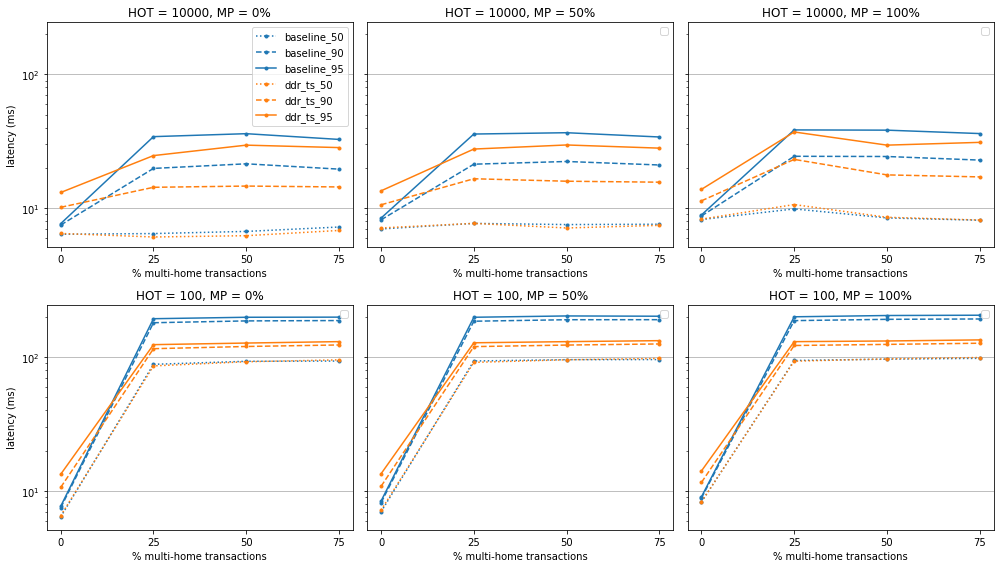

In [10]:
remove_constant_columns(latency_sh_df, ["config_name"])
plot_latency(latency_sh_df)

In [121]:
tmp = latency(spark, [
    "file:/home/ctring/data/slog/main/ycsb-latency/baseline-hot100mp100mh50",
    "file:/home/ctring/data/slog/main/ycsb-latency/ddr_ts-hot100mp100mh50"
])\
.where(F.size("replicas") == 1)\
.toPandas().merge(lat_index_df, on="prefix")

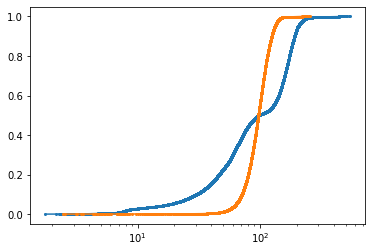

In [105]:
_, ax = plt.subplots(1, 1)
plot_cdf(tmp.loc[tmp["config_name"] == "baseline.conf", "latency"], ax=ax)
plot_cdf(tmp.loc[tmp["config_name"] == "ddr_ts.conf", "latency"], ax=ax)

## Multi-home

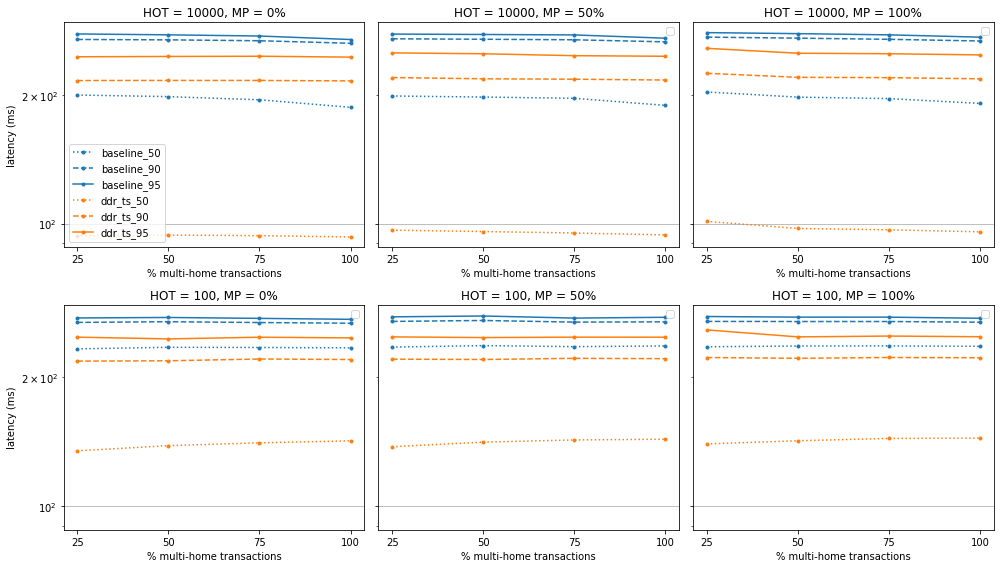

In [11]:
remove_constant_columns(latency_sh_df, ["config_name"])
plot_latency(latency_mh_df)

In [108]:
tmp = latency(spark, [
    "file:/home/ctring/data/slog/main/ycsb-latency/baseline-hot10000mp100mh50",
    "file:/home/ctring/data/slog/main/ycsb-latency/ddr_ts-hot10000mp100mh50"
])\
.where(F.size("replicas") > 1)\
.toPandas().merge(lat_index_df, on="prefix")

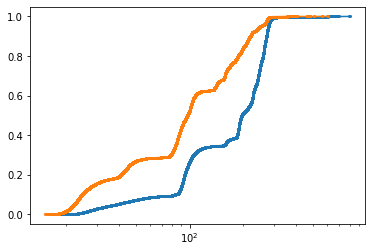

In [109]:
_, ax = plt.subplots(1, 1)
plot_cdf(tmp.loc[tmp["config_name"] == "baseline.conf", "latency"], ax=ax)
plot_cdf(tmp.loc[tmp["config_name"] == "ddr_ts.conf", "latency"], ax=ax)